In [6]:
import tensorflow as tf
import os
import numpy as np
import glob
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import ZeroPadding2D
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import joblib
from utils.plot_map import plot_feature_on_map
from datetime import datetime

In [7]:
data_path = "../../../../../../../Volumes/T7 Shield/preprocessed_new_exp1_full"
# data_path = "../../data/preprocessed_new"

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
# for results,model and scaler
folder_path = "../plots/u-net-interpolated/flux/" + timestamp
os.makedirs(folder_path, exist_ok=True)

feature_files = [os.path.join(data_path, f"{i}_features.npy") for i in range(1, 733)]
target_files = [os.path.join(data_path, f"{i}_targets.npy") for i in range(1, 733)]

features = np.stack([np.load(fp) for fp in feature_files])
targets = np.stack([np.load(fp) for fp in target_files])
  
targets = targets[..., 2]

print(targets.shape)
print(features.shape)

(732, 167, 360)
(732, 167, 360, 16)


In [ ]:
mask = features[..., 11] == 0 
# setting this feature to zero for land points because it had some random values
features[..., 5][mask] = 0 

In [ ]:
# features = features[...,[0,1,2,3,4,5,6,7,8,9,11,13,14]]

In [22]:
X_train = features[:int(0.8 * len(features))]
Y_train = targets[:int(0.8 * len(targets))]
X_val = features[int(0.8 * len(features)):int(0.9 * len(features))]
Y_val = targets[int(0.8 * len(targets)):int(0.9 * len(targets))]
X_test = features[int(0.9 * len(features)):]
Y_test = targets[int(0.9 * len(targets)):]

scaler = MinMaxScaler()
n_samples, h, w, n_features = X_train.shape
X_train_flat = X_train.reshape(-1,n_features)
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train = X_train_scaled_flat.reshape(n_samples, h, w, n_features)


n_samples, h, w, n_features = X_val.shape
X_val_flat = X_val.reshape(-1,n_features)
X_val_scaled_flat = scaler.transform(X_val_flat)
X_val = X_val_scaled_flat.reshape(n_samples, h, w, n_features)

n_samples, h, w, n_features = X_test.shape
X_test_flat = X_test.reshape(-1,n_features)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_test = X_test_scaled_flat.reshape(n_samples, h, w, n_features)

joblib.dump(scaler, folder_path + '/scaler.pkl')

['../plots/u-net-interpolated/flux/2025-05-30_14-53/scaler.pkl']

In [25]:
lr = 0.0002
loss_function = 'Huber(delta=2.0)'
batch_size = 1

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    # c1 = layers.BatchNormalization()(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    # c2 = layers.BatchNormalization()(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    # c3 = layers.BatchNormalization()(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bn = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    # bn = layers.BatchNormalization()(bn)
    bn = Conv2D(256, (3, 3), activation='relu', padding='same')(bn)

    # Decoder
    u1 = UpSampling2D((2, 2))(bn)
    u1 = Conv2D(128, (2, 2), activation='relu', padding='same')(u1)
    u1_padded = ZeroPadding2D(((1, 0), (0, 0)))(u1)  
    m1 = concatenate([u1_padded, c3])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(m1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = Conv2D(64, (2, 2), activation='relu', padding='same')(u2)
    u2_padded = ZeroPadding2D(((1, 0), (0, 0)))(u2)  
    m2 = concatenate([u2_padded, c2])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(m2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u3 = UpSampling2D((2, 2))(c5)
    u3 = Conv2D(32, (2, 2), activation='relu', padding='same')(u3)
    u3_padded = ZeroPadding2D(((1, 0), (0, 0)))(u3)  
    m3 = concatenate([u3_padded, c1])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(m3)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    # Output
    outputs = Conv2D(1, (1, 1), activation='linear')(c6)
    masked_outputs = layers.Lambda(lambda x: x[0] * tf.expand_dims(x[1][:, :, :, 11], axis=-1))([outputs, inputs])

    model = Model(inputs=inputs, outputs=masked_outputs)

    return model

model = unet_model((167, 360, 13))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.Huber(delta=2.0), metrics=['mae'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 167, 360,  │          0 │ -                 │
│ (InputLayer)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 167, 360,  │      3,776 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 167, 360,  │      9,248 │ conv2d_54[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 83, 180,   │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 83, 180,   │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 83, 180,   │     36,928 │ conv2d_56[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 41, 90,    │          0 │ conv2d_57[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 41, 90,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 41, 90,    │    147,584 │ conv2d_58[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 20, 45,    │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 20, 45,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 20, 45,    │    590,080 │ conv2d_60[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 40, 90,    │          0 │ conv2d_61[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 40, 90,    │    131,200 │ up_sampling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 41, 90,    │          0 │ conv2d_62[0][0]   │
│ (ZeroPadding2D)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 41, 90,    │          0 │ zero_padding2d_9… │
│ (Concatenate)       │ 256)              │            │ conv2d_59[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 41, 90,    │    295,040 │ concatenate_9[0]

 Total params: 1,928,481 (7.36 MB)

 Trainable params: 1,928,481 (7.36 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    batch_size=batch_size,  
    epochs=10,  # Number of training epochs
    callbacks=[lr_scheduler, early_stopping],
)

Epoch 1/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 141s 237ms/step - loss: 0.4134 - mae: 0.5601 - val_loss: 0.2665 - val_mae: 0.4304 - learning_rate: 2.0000e-04
Epoch 2/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 137s 234ms/step - loss: 0.1961 - mae: 0.3615 - val_loss: 0.2621 - val_mae: 0.4242 - learning_rate: 2.0000e-04
Epoch 3/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 138s 237ms/step - loss: 0.1439 - mae: 0.3032 - val_loss: 0.2142 - val_mae: 0.3815 - learning_rate: 2.0000e-04
Epoch 4/10
574/585 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.1287 - mae: 0.2837

KeyboardInterrupt: 

In [ ]:
model.save(folder_path + "/model.keras")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_pred = model.predict(X_test)
pred = test_pred.reshape(-1)
truth = Y_test.reshape(-1)

# test_pred = target_scaler.inverse_transform(test_pred)

# computiung mse and mae for ocean points only
mask = X_test.reshape(-1,16)
mask = mask[:, 11] == 1
pred = pred[mask]
truth = truth[mask]

mse = mean_squared_error(pred, truth)
mae = mean_absolute_error(pred, truth)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Mean Squared Error: 0.29
Mean Absolute Error: 0.34


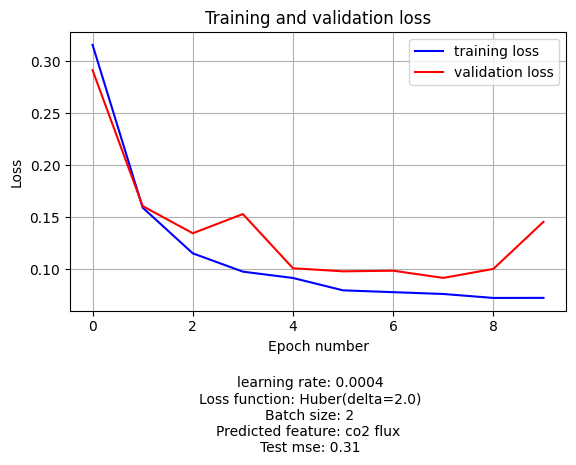

In [ ]:
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: co2 flux \nTest mse: {mse:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = folder_path + '/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [ ]:
# feature_files = [os.path.join(data_path, f"{i}_features.npy") for i in range(721, 722)]
# target_files = [os.path.join(data_path, f"{i}_targets.npy") for i in range(721, 722)]

# features = np.load(os.path.join(data_path, f"721_features.npy"))
# targets = np.load(os.path.join(data_path, f"721_targets.npy"))

# targets = targets[..., 2:3]

# h, w, n_features = features.shape
# features_flat = features.reshape(-1,n_features)
# features_scaled_flat = scaler.fit_transform(features_flat)
# features = features_scaled_flat.reshape(h, w, n_features)

# features_batched = np.expand_dims(features, axis=0)
# reconstruction = model.predict(features_batched)
# reconstruction = reconstruction[0]

# diff = reconstruction - targets

# map_like = diff.reshape(150, 360,1)


# plot_feature_on_map(map_like,-75,75,0,folder_path, 'CO2 Flux - absolute error for january 2018')

In [ ]:
feature_files = [os.path.join(data_path, f"{i}_features.npy") for i in range(721, 733)]
target_files = [os.path.join(data_path, f"{i}_targets.npy") for i in range(721, 733)]

X = np.stack([np.load(fp) for fp in feature_files])
Y = np.stack([np.load(fp) for fp in target_files])

Y = Y[..., 2]

mask = X[0,:,:,11] == 1

# folder_path = "../plots/u-net-interpolated/flux/2025-05-27_17-44"
# model = tf.keras.models.load_model(folder_path + "/model.keras", safe_mode=False)
feature_scaler= joblib.load(folder_path + "/scaler.pkl")

n_samples, h, w, n_features = X.shape
X_flat = X.reshape(-1,n_features)
X_scaled_flat = feature_scaler.transform(X_flat)
X_scaled = X_scaled_flat.reshape(n_samples, h, w, n_features)

reconstruction = model.predict(X_scaled)
reconstruction = reconstruction.reshape(n_samples, h, w)
diff = abs(reconstruction-Y)

averaged_reconstruction = np.mean(reconstruction, axis=0) * mask
averaged_truth = np.mean(Y, axis=0) * mask
averaged_diff = np.mean(diff, axis=0) * mask
plot_feature_on_map(averaged_diff,-77,90,0,2,folder_path, 'averaged_reconstruction_error','CO2 Flux - average absolute error for January 2018')
plot_feature_on_map(averaged_truth,-77,90,-5,5,folder_path, 'averaged_target','CO2 Flux - average target for January 2018')
plot_feature_on_map(averaged_reconstruction,-77,90,-5,5,folder_path, 'averaged_reconstruction','CO2 Flux - average reconstruction for January 2018')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
